## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the lead scoring dataset. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).


In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not. 


In [1]:
!wget "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv" -O data.csv

--2025-10-24 20:34:18--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]  78.98K  --.-KB/s    in 0.006s  

2025-10-24 20:34:18 (13.7 MB/s) - ‘data.csv’ saved [80876/80876]



In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('data.csv')
df.shape

(1462, 9)

In [4]:
df.columns

Index(['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income',
       'employment_status', 'location', 'interaction_count', 'lead_score',
       'converted'],
      dtype='object')

### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`



In [5]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [6]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [7]:
categorical = df.select_dtypes(include=['object']).columns.tolist()
numerical = df.select_dtypes(include=['int64', 'float64']).columns.tolist() 
numerical.remove('converted')

In [8]:
categorical, numerical

(['lead_source', 'industry', 'employment_status', 'location'],
 ['number_of_courses_viewed',
  'annual_income',
  'interaction_count',
  'lead_score'])

In [9]:
df[numerical] = df[numerical].fillna(0.0)
df[categorical] = df[categorical].fillna('NA')

In [10]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`


In [12]:
for label in (numerical):
    score = roc_auc_score(df['converted'],df[label])
    if (score < 0.5):
        print ("recalculating for -", label)
        score = roc_auc_score(-df['converted'],df[label])
    print(f'{label}: {score:.3f}')

number_of_courses_viewed: 0.761
annual_income: 0.543
interaction_count: 0.722
lead_score: 0.615


Answer 1: number_of_courses_viewed has the highest AUC with 0.761

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

In [13]:
dv = DictVectorizer(sparse=False)

def train_model(df_train, dv, C=1.0):
    train_dicts = df_train[categorical + numerical].to_dict(orient='records')
    X_train = dv.fit_transform(train_dicts)
    y_train = df_train['converted'].values
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return model

model = train_model(df_train, dv)

def predict_val(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    y = df['converted'].values
    y_pred = model.predict_proba(X)[:, 1]
    return y, y_pred

y_val, y_val_pred = predict_val(df_val, dv, model)

print(round(roc_auc_score(y_val, (y_val_pred>=0.5)) , 3))


print (y_val_pred[::10]>=0.5, y_val[::10])
print(y_val.mean(), (y_val_pred>=0.5).mean())

0.648
[ True  True  True  True  True  True False  True  True False  True  True
 False False  True  True  True  True False  True  True  True False  True
  True  True  True  True  True  True] [1 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1]
0.5836177474402731 0.8361774744027304


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

In [14]:
def get_precision_recall(y, y_pred, t=0.5):
    actual_positive = (y == 1)
    actual_negative = (y == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    print (f'Threshold: {t:.2f}  Precision: {precision:.3f}  Recall: {recall:.3f}, TP: {tp} FP: {fp} TN: {tn} FN: {fn}')
    return precision, recall


In [25]:
thresholds = np.arange(0.0, 1.0, 0.01)
scores = []
for t in thresholds:
    precision, recall = get_precision_recall(y_val, y_val_pred, t)
    scores.append((t, precision, recall))

print (scores[::10])

Threshold: 0.00  Precision: 0.584  Recall: 1.000, TP: 171 FP: 122 TN: 0 FN: 0
Threshold: 0.01  Precision: 0.584  Recall: 1.000, TP: 171 FP: 122 TN: 0 FN: 0
Threshold: 0.02  Precision: 0.584  Recall: 1.000, TP: 171 FP: 122 TN: 0 FN: 0
Threshold: 0.03  Precision: 0.584  Recall: 1.000, TP: 171 FP: 122 TN: 0 FN: 0
Threshold: 0.04  Precision: 0.584  Recall: 1.000, TP: 171 FP: 122 TN: 0 FN: 0
Threshold: 0.05  Precision: 0.584  Recall: 1.000, TP: 171 FP: 122 TN: 0 FN: 0
Threshold: 0.06  Precision: 0.584  Recall: 1.000, TP: 171 FP: 122 TN: 0 FN: 0
Threshold: 0.07  Precision: 0.584  Recall: 1.000, TP: 171 FP: 122 TN: 0 FN: 0
Threshold: 0.08  Precision: 0.584  Recall: 1.000, TP: 171 FP: 122 TN: 0 FN: 0
Threshold: 0.09  Precision: 0.584  Recall: 1.000, TP: 171 FP: 122 TN: 0 FN: 0
Threshold: 0.10  Precision: 0.584  Recall: 1.000, TP: 171 FP: 122 TN: 0 FN: 0
Threshold: 0.11  Precision: 0.584  Recall: 1.000, TP: 171 FP: 122 TN: 0 FN: 0
Threshold: 0.12  Precision: 0.584  Recall: 1.000, TP: 171 FP: 12

/tmp/ipykernel_30094/3978718992.py:14: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


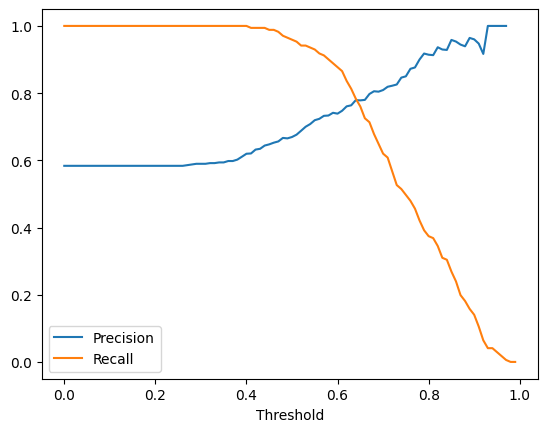

In [26]:
import matplotlib.pyplot as plt
plt.plot([x[0] for x in scores], [x[1] for x in scores], label='Precision')
plt.plot([x[0] for x in scores], [x[2] for x in scores], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.show()

Answer 3: Precision and Recall seem to intersect around t=0.645 between .64 and .65

Threshold: 0.63  Precision: 0.765  Recall: 0.819, TP: 140 FP: 43 TN: 79 FN: 31 

Threshold: 0.64  Precision: 0.770  Recall: 0.784, TP: 134 FP: 40 TN: 82 FN: 37

Threshold: 0.65  Precision: 0.778  Recall: 0.760, TP: 130 FP: 37 TN: 85 FN: 41

Threshold: 0.66  Precision: 0.783  Recall: 0.737, TP: 126 FP: 35 TN: 87 FN: 45

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74

In [27]:
f1scores = []
for score in scores:
    f1score = 2 * (score[1] * score[2]) / (score[1] + score[2])
    f1scores.append([score[0],f1score])
    print (score[0], round(f1score, 3))



0.0 0.737
0.01 0.737
0.02 0.737
0.03 0.737
0.04 0.737
0.05 0.737
0.06 0.737
0.07 0.737
0.08 0.737
0.09 0.737
0.1 0.737
0.11 0.737
0.12 0.737
0.13 0.737
0.14 0.737
0.15 0.737
0.16 0.737
0.17 0.737
0.18 0.737
0.19 0.737
0.2 0.737
0.21 0.737
0.22 0.737
0.23 0.737
0.24 0.737
0.25 0.737
0.26 0.737
0.27 0.739
0.28 0.74
0.29 0.742
0.3 0.742
0.31 0.742
0.32 0.743
0.33 0.743
0.34 0.745
0.35000000000000003 0.745
0.36 0.748
0.37 0.748
0.38 0.752
0.39 0.758
0.4 0.765
0.41000000000000003 0.764
0.42 0.773
0.43 0.774
0.44 0.782
0.45 0.782
0.46 0.786
0.47000000000000003 0.787
0.48 0.79
0.49 0.788
0.5 0.788
0.51 0.791
0.52 0.795
0.53 0.803
0.54 0.806
0.55 0.811
0.56 0.809
0.5700000000000001 0.812
0.58 0.808
0.59 0.809
0.6 0.802
0.61 0.802
0.62 0.797
0.63 0.788
0.64 0.781
0.65 0.769
0.66 0.752
0.67 0.753
0.68 0.737
0.6900000000000001 0.718
0.7000000000000001 0.702
0.71 0.698
0.72 0.671
0.73 0.643
0.74 0.64
0.75 0.627
0.76 0.619
0.77 0.6
0.78 0.574
0.79 0.549
0.8 0.531
0.81 0.525
0.8200000000000001 0.504

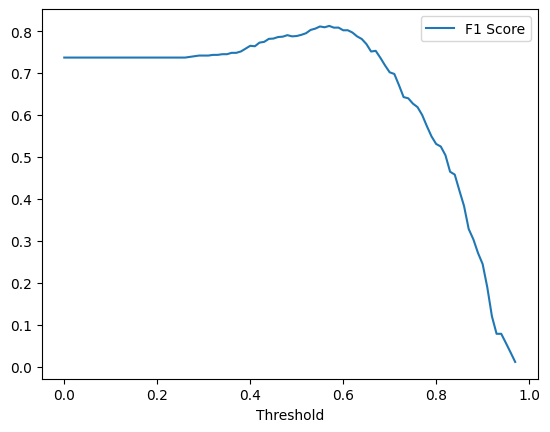

In [28]:
plt.plot([x[0] for x in f1scores], [x[1] for x in f1scores], label='F1 Score')
plt.xlabel('Threshold')
plt.legend()
plt.show()

Amswer 4: 0.55

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [30]:
!pip install tqdm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [31]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [32]:
n_splits = 5
aucs = []
dv = DictVectorizer(sparse=False)

def train_model_nfold(df, dv, n_splits=5, C=1.0, t=0.5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    for train_index, val_index in tqdm(kf.split(df), total=n_splits):
        df_train = df.iloc[train_index]
        df_val = df.iloc[val_index]

        model = train_model(df_train, dv, C=C)
        y_val, y_val_pred = predict_val(df_val, dv, model)
        auc = roc_auc_score(y_val, y_val_pred>=t)
        aucs.append(auc)
    return aucs

aucs = train_model_nfold(df_full_train, dv, n_splits=n_splits)
print(f'CV mean ROC AUC: {np.mean(aucs):.3f}, SD: {np.std(aucs):.3f}')


  0%|          | 0/5 [00:00<?, ?it/s]

CV mean ROC AUC: 0.664, SD: 0.025


Answer 5: 0.06? Value = 0.025. 

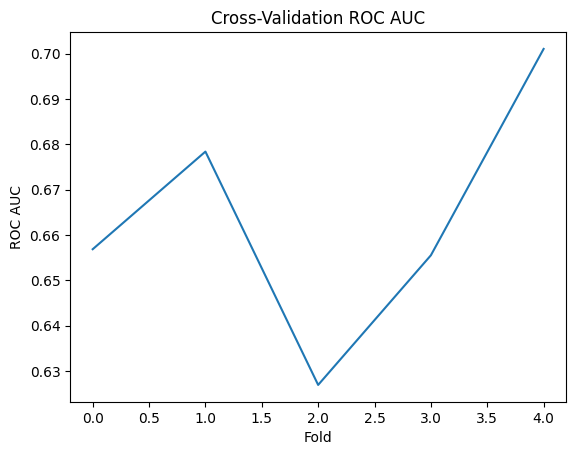

In [33]:
plt.plot(aucs)
plt.xlabel('Fold')
plt.ylabel('ROC AUC')
plt.title('Cross-Validation ROC AUC')
plt.show()

### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [37]:
C_values = [0.000001, 0.001, 1]
mean_aucs = []
n_splits = 5
for C in C_values:
    aucs = train_model_nfold(df_full_train, dv, n_splits=n_splits, C=C, t=0.5)
    mean_auc = np.mean(aucs)
    mean_aucs.append((C, mean_auc))
    print(f'C={C}: CV mean ROC AUC: {mean_auc:.3f}, SD: {np.std(aucs):.3f}')


  0%|          | 0/5 [00:00<?, ?it/s]

C=1e-06: CV mean ROC AUC: 0.562, SD: 0.078


  0%|          | 0/5 [00:00<?, ?it/s]

C=0.001: CV mean ROC AUC: 0.558, SD: 0.076


  0%|          | 0/5 [00:00<?, ?it/s]

C=1: CV mean ROC AUC: 0.566, SD: 0.079


Answer: C=1 seems to have tbe best mean across multiple runs. 

## Submit the results

* Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2025/homework/hw04
* If your answer doesn't match options exactly, select the closest one